In [1]:
import cv2 # to turn an image black-and-white and to turn it into a data matrix
import numpy as np
import matplotlib.pyplot as plt
import os # to find number of images in directory
import csv # to save the output to a csv file
import warnings # for large exponentials in the sigmoid function
warnings.filterwarnings('ignore')

### The program assumes that the folders "Real", "Fake" and "FutureData" are in the root folder of the jupyter notebook.

# Part I

This function calculates the azimuthal average of the magnitude of a single image.

In [2]:
def intensityCalculator(img):
    # bin_size sets how many pixels we include in addition to
    # the exact radial distance we are looking for
    bin_size = 1
    # create a grid centered around the highest energy point
    a = img.shape[0]
    b = img.shape[1]
    center = np.where(img == img.max())
    cen_x = center[0][0]
    cen_y = center[1][0]
    [X, Y] = np.meshgrid(np.arange(b) - cen_x, np.arange(a) - cen_y)
    # calculating possible radii from the image center in pixel value
    R = np.sqrt(np.square(X) + np.square(Y)) # element-wise square
    rad = np.arange(1, np.max(R), 1)
    intensity = np.zeros(len(rad))
    index = 0
    for i in rad:
        mask = (np.greater(R, i-bin_size) & np.less(R, i+bin_size))
        values = img[mask]
        intensity[index] = np.mean(values)
        index += 1
    return rad, intensity

This function calculates each subsection of section 1:<br>
a:
Read images from files.<br>
b, c, d:
Calculate and shift the discrete fourier transform of each image and add $ 10^{-8} $.<br>
e: Calculate the magnitude by $ 20\log \left| \cdot \right| $.<br>
f: Calculate azimuthal average of the magnitude.

In [3]:
def processImage(img_path):
    # section a: Read images from files
    processed_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # sections b,c,d: Calculate and shift the discrete
    # fourier transform and add 10^-8
    processed_img = np.fft.fftshift(np.fft.fft2(processed_img)) + pow(10, -8)
    # section e: Calculate the magnitude by 20log||
    processed_img = 20*np.log(np.abs(processed_img))
    # section f: Calculate the azimuthal average of the magnitude
    rad, intensity = intensityCalculator(processed_img)
    return rad, intensity

In [4]:
def getImagesFromDirectory(directory_name, starting_idx):
    imgs_count = len(os.listdir(directory_name))
    
    radii = 724
    
    filenames = [None]*imgs_count
    rad_list = [None]*imgs_count
    intensity_mat = np.zeros([imgs_count, radii])
    for i in range(imgs_count):
        filenames[i] = directory_name + '/' + str(starting_idx+i) + '.jpg'
        rad_list[i], intensity_mat[i,:] = processImage(filenames[i])
        if (i%100==99): # to track progress
            print(i)
    
    return rad_list, intensity_mat, filenames

In [5]:
fake_rad_list, fake_intensity_mat, fake_filenames = getImagesFromDirectory("Fake", 0)
real_rad_list, real_intensity_mat, real_filenames = getImagesFromDirectory("Real", 0)

99
199
299
399
499
99
199
299
399
499


In [6]:
# meant to fit the matrix indices to the requested indices from the project description
def cutFirstAndLastRadiiAndIntensity(rad_list, intensity_mat):
    length = len(rad_list)
    for i in range(length):
        rad_list[i] = rad_list[i][1:-1]
    intensity_mat = intensity_mat[:, 1:-1]
    return rad_list, intensity_mat

In [7]:
real_rad_list, real_intensity_mat = cutFirstAndLastRadiiAndIntensity(real_rad_list, real_intensity_mat)
fake_rad_list, fake_intensity_mat = cutFirstAndLastRadiiAndIntensity(fake_rad_list, fake_intensity_mat)

In [8]:
real_intensity_mat.shape

(500, 722)

In [9]:
fake_intensity_mat.shape

(500, 722)

# Part II

### 2 - Gradient Descent

In [10]:
def sigma(w, x):
    return 1/(1 + np.exp(-x @ w))

In [11]:
def gradientDescent(w0, xn, tn, alpha, m):
    N = len(tn)
    w = np.copy(w0)
    sum = np.zeros(len(w0))
    
    for j in range(m):
        sum = sum*0
        # calculate the inner sum
        for i in range(N):
            sum += xn[i,:] * (sigma(w.T, xn[i,:]) - tn[i])
        sum = alpha * sum
        w = w - sum
    
    return w

Returns all values of $w^{(j)}$, $ 1\leq j \leq m $,  in a matrix, for plotting purposes:

In [12]:
def gradientDescentAllW(w0, xn, tn, alpha, m):
    N = len(tn)
    w_arr = np.zeros([m, len(w0)])
    w = w0
    sum = np.zeros(len(w0))
    
    for j in range(m):
        sum = sum*0
        # calculate the inner sum
        for i in range(N):
            sum += xn[i,:] * (sigma(w.T, xn[i,:]) - tn[i])
        sum = alpha * sum
        w = w - sum
        w_arr[j,:] = w
    
    return w_arr

In [13]:
# required: data_mat.shape[0] / ratio is an integer
def splitData(data_mat, ratio):
    if (data_mat.shape[0] % ratio != 0):
        return -1
    return np.split(data_mat, ratio)

The following function receives a list of split data and returns an array of train data and an array of test data as requested in `test_split_idx`.

In [14]:
def kFoldData(data_list, test_split_idx):
    if (len(data_list) <= test_split_idx):
        return -1, -1
    # test data split
    Xtest = np.copy(data_list[test_split_idx])
    # train data split
    Xtrain = np.zeros([data_list[0].shape[0]*(len(data_list)-1), data_list[0].shape[1]])
    j = 0
    for i in range(test_split_idx): # before the test split
        Xtrain[i*data_list[0].shape[0]:(i+1)*data_list[0].shape[0],:] = data_list[i]
        j += 1
    for i in np.arange(test_split_idx+1, len(data_list), 1): # after the test split
        Xtrain[j*data_list[0].shape[0]:(j+1)*data_list[0].shape[0],:] = data_list[i]
        j += 1
    return Xtrain, Xtest

In [15]:
def addOnesCol(mat):
    return np.concatenate((np.ones([mat.shape[0], 1]), mat), 1)

In [16]:
def addZerosCol(mat):
    return np.concatenate((np.zeros([mat.shape[0], 1]), mat), 1)

In [17]:
def probabilityMat(probabilities_vector, threshold):
    probability_mat = np.array(probabilities_vector, copy = 'True')
    for i in range(len(probability_mat)):
        if (probability_mat[i] > threshold):
            probability_mat[i] = 1
        else:
            probability_mat[i] = 0
    return probability_mat

In [18]:
def confusionMat(probability_vector, target_vector):
    confusion_mat = np.zeros([2, 2])
    l = len(probability_vector)
    for i in range(l):
        if (probability_vector[i] == 1):
            # True Positive
            if (target_vector[i] == 1):
                confusion_mat[0][0] += 1
            # False Positive
            else:
                confusion_mat[0][1] += 1
        else:
            # False Negative
            if (target_vector[i] == 1):
                confusion_mat[1][0] += 1    
            # True Negative
            else:
                confusion_mat[1][1] += 1
    return confusion_mat

In [19]:
def ROCValuesGenerator(confusion_mat):
    tp = confusion_mat[0][0]
    fp = confusion_mat[0][1]
    fn = confusion_mat[1][0]
    tn = confusion_mat[1][1]
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    # true positive rate
    tpr = tp/(tp+fn)
    # false positive rate
    fpr = fp/(fp+tn)
    accuracy = (tp+tn)/(tp + tn + fp + fn)
#     return recall, precision, tpr, fpr, accuracy
    return tpr, fpr, accuracy

In [20]:
def L_CE(x, y, w):
    N = x.shape[0]
    w_T = w.T
    sum = 0
    for i in range(N):
        temp = sigma(w_T, x[i])
        if (y[i] == 1):
            sum += y[i]*np.log(temp)
        if (y[i] == 0):
            sum += (1-y[i])*np.log(1-temp)
    return -sum

The following function calculates the accuracy, the confusion matrix and the cross-entropy of a given fold.<br>
1. `x` - xtrain
2. `y` - ytrain
3. `w` - coefficients
4. `threshold` - classify as 0 or 1 according to threshold

In [21]:
def getAccuracyConfusionMatLCE(x, y, w, threshold):
    x_probability = sigma(w, x)
    x_prob_mat = probabilityMat(x_probability, threshold)
    confusion_mat = confusionMat(x_prob_mat, y)
    accuracy = ROCValuesGenerator(confusion_mat)
    ce = L_CE(x, y, w)
    return accuracy[2], confusion_mat, ce

In [22]:
def normalizeMatCols(mat):
    cols_mean = np.mean(mat, 0)
    cols_std = np.std(mat, 0)
    norm_mat = (mat - cols_mean) / cols_std
    return norm_mat

The following function recevies a complete data set `x` (in our case, 1000 images), divides it into `folds` folds, invokes `gradientDescent` function with `m` iterations and `alpha` as the learning rate. 
<br>
`threshold` is passed to the function `getAccuracyConfusionMatLCE` to calculate the accuracy of each fold.
<br>
Output:<br>
1. `x` - the complete data set, after shuffling.
2. `y` - the true/false (real/fake) values of each image. 1-fake, 0-real.
3. `folds_data_list` - contains the xtrain, ytrain, xtest, ytest of each fold, in each of its elements.
4. `wm_list` - contains the coefficients calculated by `gradientDescent` for each fold, stored in each of its elements as a matrix of all steps up to and including `m`.
5. `accuracy_list` - contains the accuracy of each fold, in each of its elements.

In [23]:
def accuracyCalcWithFolds(x, m, w0_value, alpha, threshold, folds):
    # x contains all 1000 images
    # copy x so as to allow change without altering x
    x1 = np.copy(x)
    # normalize data
    x1 = normalizeMatCols(x1)
    # first 500 images are fake - tag 1
    x1 = addZerosCol(x1)
    # last 500 images are real - tag 0
    x1[0:int(x1.shape[0]/2),0] = 1
    
    # shuffle the data
    rng = np.random.default_rng()
    rng.shuffle(x1, 0)
    y1 = np.copy(x1[:,0])
    
    # split the data according to folds
    # data is now in a list, in which each element
    # is an np.ndarray of data
    split_data_list = splitData(x1, folds)
    
    # lists to save all the data from each fold
    folds_data_list = [None]*folds
    accuracy_list = [None]*folds
    wm_list = [None]*folds
    for i in range(folds):
        x1_train, x1_test = kFoldData(split_data_list, i)
        # save images' tags in y1_train, y1_test
        y1_train = np.copy(x1_train[:,0])
        y1_test = np.copy(x1_test[:,0])
        # adjust first index in x1_train, x1_test to 1's
        # for the regression
        x1_train[:,0] = 1
        x1_test[:,0] = 1
        # save the current fold to return at the end
        folds_data_list[i] = [x1_train, y1_train, x1_test, y1_test]
        # invoke gradient descent algorithm
        w0 = np.ones(x1_train.shape[1]) * w0_value
        # save the coefficients of the current fold to return
        wm_list[i] = gradientDescentAllW(w0, x1_train, y1_train, alpha, m)
        # calculate the accuracy for each fold
        # wm_list[i][-1] - the last wm, according to m
        train_accuracy, train_confusion_mat, train_ce = getAccuracyConfusionMatLCE(x1_train, y1_train, wm_list[i][-1], threshold)
        test_accuracy, test_confusion_mat, test_ce = getAccuracyConfusionMatLCE(x1_test, y1_test, wm_list[i][-1], threshold)
        # save the accuracy of the current fold to return
        accuracy_list[i] = [train_accuracy, test_accuracy]
    return x1, y1, folds_data_list, wm_list, accuracy_list

### Invoking gradient descent

In [24]:
data_mat = np.concatenate((fake_intensity_mat, real_intensity_mat))

In [25]:
m = 70
w0 = 0.001
alpha = 0.08
threshold = 0.5
folds = 4
x1, y1, folds_data_list, wm_list, accuracy_list = accuracyCalcWithFolds(data_mat, m, w0, alpha, threshold, folds)

#### Graph of cross-entropy change over $w^{(0)}$

In [26]:
def getLCEOverW0(x, y, w0_arr, alpha, m):
    lce_arr = np.zeros(len(w0_arr))
    length = len(lce_arr)
    for i in range(length):
        wm = gradientDescent(w0_arr[i], x, y, alpha, m)
        lce_arr[i] = L_CE(x,y,wm)
    return lce_arr

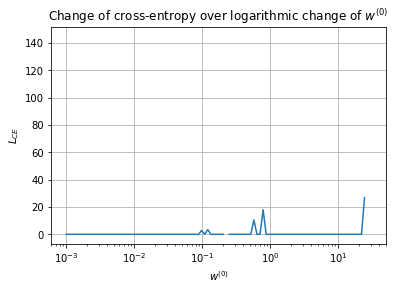

In [27]:
fold = 2

w0_arr = np.geomspace(30, 0.001, 100)
# duplicate each w0 723 times over a row. each row has a different w0
w0_mat = np.tile(w0_arr, (folds_data_list[fold][0].shape[1], 1)).T
lce_over_w0 = getLCEOverW0(folds_data_list[fold][0], folds_data_list[fold][1], w0_mat, alpha, m)

plt.plot(w0_arr, lce_over_w0)
plt.xscale('log')
plt.title("Change of cross-entropy over logarithmic change of $w^{(0)}$")
plt.xlabel('$w^{(0)}$')
plt.ylabel('$L_{CE}$')
plt.grid()

#### Graph of cross-entropy change over $\alpha$

The following function calculates all $\mathcal{L}_{CE}$ values up to a requested value of $\alpha$ on a logarithmic scale:

In [51]:
def getLCEOverAlpha(w0, x, y, alpha_arr, m):
    lce_arr = np.zeros(len(alpha_arr))
    length = len(lce_arr)
    for i in range(length):
        wm = gradientDescent(w0, x, y, alpha_arr[i], m)
        lce_arr[i] = L_CE(x, y, wm)
        if (i%9==0): # to track progress
            print(i)
    return lce_arr

0
9
18
27
36
45
54
63
72
81
90
99
Lowest LCE value: 1.560973572623092e-13
Corresponding alpha of minimum LCE: 0.1


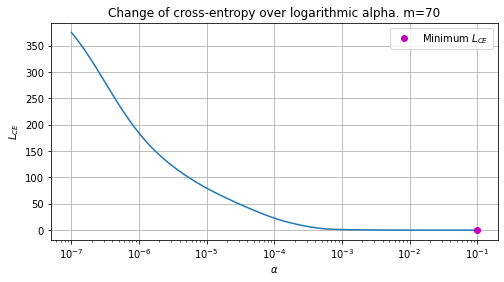

In [29]:
fold = 2

alpha_arr = np.geomspace(10**(-7), 10**(-1), 100)
w0_vec = np.ones(folds_data_list[fold][0].shape[1]) * w0
lce_over_alpha_arr =  getLCEOverAlpha(w0_vec, folds_data_list[fold][0], folds_data_list[fold][1], alpha_arr, m)

plt.plot(alpha_arr, lce_over_alpha_arr)
plt.xscale("log")
plt.title("Change of cross-entropy over logarithmic alpha. m=" + str(m))
plt.xlabel('$ \\alpha $')
plt.ylabel('$ L_{CE} $')
plt.grid()
plt.gcf().set_size_inches(8, 4)

lowest_lce = np.min(lce_over_alpha_arr)
best_alpha = alpha_arr[np.where(lowest_lce == lce_over_alpha_arr)][0]

label_alpha = 'Minimum $L_{CE}$'
plt.plot(best_alpha, lowest_lce, 'mo', label = label_alpha)
plt.legend();

print('Lowest LCE value: ' + str(lowest_lce))
print('Corresponding alpha of minimum LCE: ' + str(best_alpha))

#### Graph of  cross-entropy change over $m$

The following function to calculates all $\mathcal{L}_{CE}$ values up to a requested value of $m$:

In [30]:
def getLCEGraphValues(x, y, wm_arr):
    lce_arr = np.zeros(wm_arr.shape[0])
    for i in range(wm_arr.shape[0]):
        lce_arr[i] = L_CE(x, y, wm_arr[i])
    return lce_arr

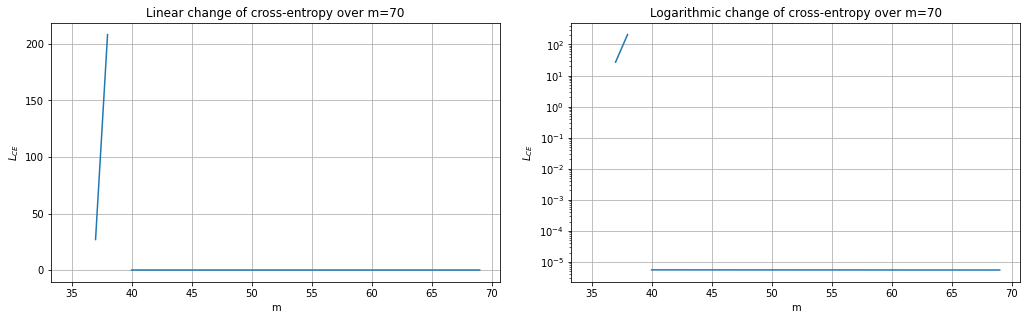

In [31]:
fold = 2

start = 35

wm_arr = wm_list[fold]
m_axis = np.arange(wm_arr.shape[0])
lce_arr = getLCEGraphValues(folds_data_list[fold][0], folds_data_list[fold][1], wm_arr)

lce_fig, lce_axes = plt.subplots(1, 2)
lce_fig.set_figheight(5)
lce_fig.set_figwidth(15)
lce_fig.tight_layout(pad=4)

lce_axes[0].plot(m_axis[start:], lce_arr[start:])
lce_axes[0].set_title('Linear change of cross-entropy over m=' + str(len(m_axis)))
lce_axes[0].set_xlabel('m')
lce_axes[0].set_ylabel('$ L_{CE} $')
lce_axes[0].grid()

lce_axes[1].plot(m_axis[start:], lce_arr[start:])
lce_axes[1].set_title('Logarithmic change of cross-entropy over m=' + str(len(m_axis)))
lce_axes[1].set_xlabel('m')
lce_axes[1].set_ylabel('$ L_{CE} $')
lce_axes[1].set_yscale("log")
lce_axes[1].grid()

#### Accuracy change over $w^{(0)}$

In [32]:
def getAccuracyOverW0(x, y, w0_arr, alpha, m, threshold):
    length = len(w0_arr)
    accuracy_over_w0 = np.zeros([length])
    for i in range(length):
        wm = gradientDescent(w0_arr[i], x, y, alpha, m)
        accuracy_over_w0[i] = getAccuracyConfusionMatLCE(x, y, wm, threshold)[0]
    return accuracy_over_w0

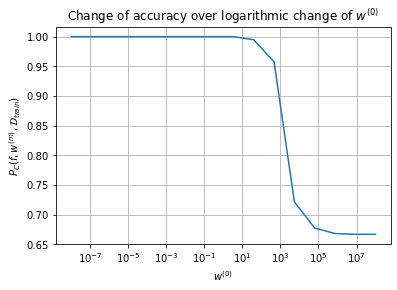

In [33]:
fold = 2

w0_arr = np.geomspace(10**8, 10**(-8), 16)
# duplicate each w0 723 times over a row. each row has a different w0
w0_mat = np.tile(w0_arr, (folds_data_list[fold][0].shape[1], 1)).T
acc_over_w0 = getAccuracyOverW0(folds_data_list[fold][0], folds_data_list[fold][1], w0_mat, alpha, m, threshold)

plt.plot(w0_arr, acc_over_w0)
plt.xscale('log')
plt.title("Change of accuracy over logarithmic change of $w^{(0)}$")
plt.xlabel('$w^{(0)}$')
plt.ylabel('$P_C(f,w^{(m)},\mathcal{D}_{train})$')
plt.grid()

#### Accuracy change over $\alpha$

In [34]:
def getAccuracyOverAlpha(x, y, w0, m, alpha_arr):
    length = len(alpha_arr)
    accuracy_over_alpha = np.zeros(length)
    for i in range(length):
        wm = gradientDescent(w0, x, y, alpha_arr[i], m)
        accuracy_over_alpha[i] = getAccuracyConfusionMatLCE(x, y, wm, threshold)[0]
    return accuracy_over_alpha

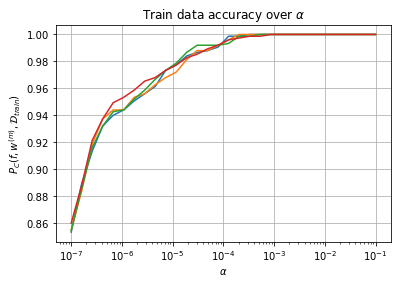

In [35]:
alpha_arr = np.geomspace(10**(-7), 10**(-1), 30)
w0_vec = np.ones(folds_data_list[fold][0].shape[1])*w0

# train accuracy
for fold in range(folds):
    train_acc_over_alpha_arr = getAccuracyOverAlpha(folds_data_list[fold][0], folds_data_list[fold][1], w0_vec, m, alpha_arr)
    m_axis = np.arange(wm_list[fold].shape[0])
    plt.plot(alpha_arr, train_acc_over_alpha_arr)

plt.title("Train data accuracy over $\\alpha$")
plt.xlabel('$\\alpha$')
plt.ylabel('$P_C(f,w^{(m)},\mathcal{D}_{train})$')
plt.grid()
plt.xscale('log')

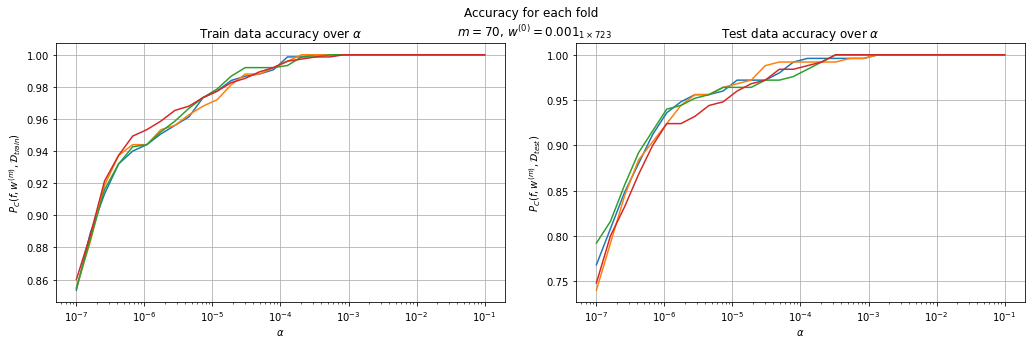

In [36]:
acc_over_alpha_fig, acc_over_alpha_axes = plt.subplots(1, 2)
acc_over_alpha_fig.set_figheight(5)
acc_over_alpha_fig.set_figwidth(15)
acc_over_alpha_fig.tight_layout(pad=4)
acc_over_alpha_fig.suptitle('Accuracy for each fold \n $m=$' + str(m) + ', $w^{(0)}=$' + str(w0) + '$_{1\\times723}$')

alpha_arr = np.geomspace(10**(-7), 10**(-1), 30)
w0_vec = np.ones(folds_data_list[fold][0].shape[1])*w0

# train accuracy
for fold in range(folds):
    train_acc_over_alpha_arr = getAccuracyOverAlpha(folds_data_list[fold][0], folds_data_list[fold][1], w0_vec, m, alpha_arr)
    m_axis = np.arange(wm_list[fold].shape[0])
    acc_over_alpha_axes[0].plot(alpha_arr, train_acc_over_alpha_arr)

# acc_over_alpha_axes[0].set_xscale('log')    
acc_over_alpha_axes[0].set_title("Train data accuracy over $\\alpha$")
acc_over_alpha_axes[0].set_xlabel('$\\alpha$')
acc_over_alpha_axes[0].set_ylabel('$P_C(f,w^{(m)},\mathcal{D}_{train})$')
acc_over_alpha_axes[0].grid()
acc_over_alpha_axes[0].set_xscale('log')

# test accuracy
for fold in range(folds):
    test_acc_over_alpha_arr = getAccuracyOverAlpha(folds_data_list[fold][2], folds_data_list[fold][3], w0_vec, m, alpha_arr)
    m_axis = np.arange(wm_list[fold].shape[0])
    acc_over_alpha_axes[1].plot(alpha_arr, test_acc_over_alpha_arr)

acc_over_alpha_axes[1].set_xscale('log')
acc_over_alpha_axes[1].set_title('Test data accuracy over $\\alpha$')
acc_over_alpha_axes[1].set_xlabel('$\\alpha$')
acc_over_alpha_axes[1].set_ylabel('$P_C(f,w^{(m)},\mathcal{D}_{test})$')
acc_over_alpha_axes[1].grid()

#### Accuracy change over m

In [37]:
def getAccuracyOverWm(x, y, wm_arr, threshold):
    length = wm_arr.shape[0]
    accuracy_over_m = np.zeros(length)
    for i in range(length):
        accuracy_over_m[i] = getAccuracyConfusionMatLCE(x, y, wm_arr[i], threshold)[0]
    return accuracy_over_m

In [38]:
def getAvgAccuracy(accuracy_list):
    avg_train_accuracy = 0
    avg_test_accuracy = 0
    l = len(accuracy_list)
    for i in range(l):
        avg_train_accuracy += accuracy_list[i][0]
        avg_test_accuracy += accuracy_list[i][1]
    return avg_train_accuracy/l, avg_test_accuracy/l

Train accuracy and test accuracy of each fold:
[[1.0, 1.0], [1.0, 0.996], [1.0, 0.996], [1.0, 1.0]]
average train accuracy for m=70: 1.0
average test accuracy for m=70: 0.998


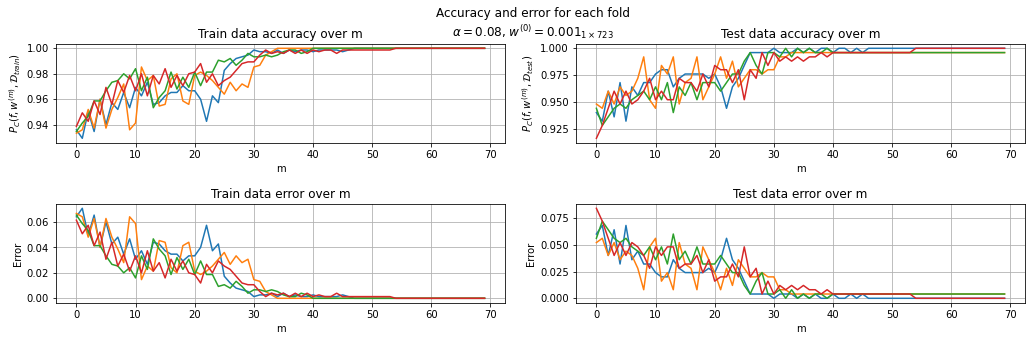

In [39]:
acc_over_m_fig, acc_over_m_axes = plt.subplots(2, 2)
acc_over_m_fig.set_figheight(5)
acc_over_m_fig.set_figwidth(15)
acc_over_m_fig.tight_layout(pad=4)
acc_over_m_fig.suptitle('Accuracy and error for each fold\n$\\alpha=$' + str(alpha) + ', $w^{(0)}=$' + str(w0) + '$_{1\\times723}$')

m_axis = np.arange(m)

# train accuracy and error
for fold in range(folds):
    acc_over_m_arr = getAccuracyOverWm(folds_data_list[fold][0], folds_data_list[fold][1], wm_list[fold], threshold)
    m_axis = np.arange(wm_list[fold].shape[0])
    acc_over_m_axes[0][0].plot(m_axis, acc_over_m_arr)
    acc_over_m_axes[1][0].plot(m_axis, 1 - acc_over_m_arr)

acc_over_m_axes[0][0].set_title("Train data accuracy over m")
acc_over_m_axes[0][0].set_xlabel('m')
acc_over_m_axes[0][0].set_ylabel('$P_C(f,w^{(m)},\mathcal{D}_{train})$')
acc_over_m_axes[0][0].grid()

acc_over_m_axes[1][0].set_title("Train data error over m")
acc_over_m_axes[1][0].set_xlabel('m')
acc_over_m_axes[1][0].set_ylabel('Error')
acc_over_m_axes[1][0].grid()

# test accuracy and error
for fold in range(folds):
    acc_over_m_arr = getAccuracyOverWm(folds_data_list[fold][2], folds_data_list[fold][3], wm_list[fold], threshold)
    m_axis = np.arange(wm_list[fold].shape[0])
    acc_over_m_axes[0][1].plot(m_axis, acc_over_m_arr)
    acc_over_m_axes[1][1].plot(m_axis, 1 - acc_over_m_arr)

acc_over_m_axes[0][1].set_title("Test data accuracy over m")
acc_over_m_axes[0][1].set_xlabel('m')
acc_over_m_axes[0][1].set_ylabel('$P_C(f,w^{(m)},\mathcal{D}_{test})$')
acc_over_m_axes[0][1].grid()

acc_over_m_axes[1][1].set_title("Test data error over m")
acc_over_m_axes[1][1].set_xlabel('m')
acc_over_m_axes[1][1].set_ylabel('Error')
acc_over_m_axes[1][1].grid()

print('Train accuracy and test accuracy of each fold:')
print(accuracy_list)

avg_train_acc, avg_test_acc = getAvgAccuracy(accuracy_list)
print('average train accuracy for m=' + str(m) +': ' + str(avg_train_acc))
print('average test accuracy for m=' + str(m) + ': ' + str(avg_test_acc))

Single graph for test data accuracy:

In [40]:
# m_axis = np.arange(m)
# for fold in range(folds):
#     acc_over_m_arr = getAccuracyOverWm(folds_data_list[fold][2], folds_data_list[fold][3], wm_list[fold], threshold)
#     m_axis = np.arange(wm_list[fold].shape[0])
#     plt.plot(m_axis, acc_over_m_arr)

# plt.title("Test data accuracy over $m$")
# plt.xlabel('$m$')
# plt.ylabel('$P_C(f,w^{(m)},\mathcal{D}_{test})$')
# plt.grid()

# print('Train accuracy and test accuracy of each fold:')
# print(accuracy_list)

# avg_train_acc, avg_test_acc = getAvgAccuracy(accuracy_list)
# # print('average train accuracy for m=' + str(m) +': ' + str(avg_train_acc))
# print('average test accuracy for m=' + str(m) + ': ' + str(avg_test_acc))

A graph for train data error and a graph for test data error:

In [41]:
# acc_over_m_fig, acc_over_m_axes = plt.subplots(1, 2)
# acc_over_m_fig.set_figheight(5)
# acc_over_m_fig.set_figwidth(15)
# acc_over_m_fig.tight_layout(pad=4)
# acc_over_m_fig.suptitle('Accuracy for each fold\n$\\alpha=$' + str(alpha) + ', $w^{(0)}=$' + str(w0) + '$_{1\\times723}$')

# m_axis = np.arange(m)

# # train accuracy
# for fold in range(folds):
#     acc_over_m_arr = getAccuracyOverWm(folds_data_list[fold][0], folds_data_list[fold][1], wm_list[fold], threshold)
#     m_axis = np.arange(wm_list[fold].shape[0])
#     acc_over_m_axes[0].plot(m_axis, acc_over_m_arr)

# acc_over_m_axes[0].set_title("Train data accuracy over m")
# acc_over_m_axes[0].set_xlabel('m')
# acc_over_m_axes[0].set_ylabel('$P_C(f,w^{(m)},\mathcal{D}_{train})$')
# acc_over_m_axes[0].grid()

# # test accuracy
# for fold in range(folds):
#     acc_over_m_arr = getAccuracyOverWm(folds_data_list[fold][2], folds_data_list[fold][3], wm_list[fold], threshold)
#     m_axis = np.arange(wm_list[fold].shape[0])
#     acc_over_m_axes[1].plot(m_axis, acc_over_m_arr)

# acc_over_m_axes[1].set_title('Test data accuracy over m')
# acc_over_m_axes[1].set_xlabel('m')
# acc_over_m_axes[1].set_ylabel('$P_C(f,w^{(m)},\mathcal{D}_{test})$')
# acc_over_m_axes[1].grid()

# print('Train accuracy and test accuracy of each fold:')
# print(accuracy_list)

# avg_train_acc, avg_test_acc = getAvgAccuracy(accuracy_list)
# print('average train accuracy for m=' + str(m) +': ' + str(avg_train_acc))
# print('average test accuracy for m=' + str(m) + ': ' + str(avg_test_acc))

### ROC graphs

The following funtion calculates the True Positive Rate and the False Positive Rate for all thresholds in a given range and returns a vector of change-over-thresholds for the TPR and for the FPR.

In [42]:
def FPRandTPR(probability_vector, targets, min_prob, max_prob, partitions):
    fpr = np.zeros(partitions)
    tpr = np.zeros(partitions)
    threshold_vector = np.linspace(min_prob, max_prob, partitions)
    
    for i in range(partitions):
        prob_mat = probabilityMat(probability_vector, threshold_vector[i])
        confusion_mat = confusionMat(prob_mat, targets)
        t, f, temp = ROCValuesGenerator(confusion_mat)
        fpr[i] = f
        tpr[i] = t
    
    return fpr, tpr

$ \mathcal{D}_{train} $  confusion Matrix:

In [43]:
for fold in range(folds):
    X = folds_data_list[fold][0]
    Y = folds_data_list[fold][1]
    wm_here = wm_list[fold][-1]
    acc, con_mat, lce = getAccuracyConfusionMatLCE(X, Y, wm_here, threshold)
    print('confusion matrix of fold #' + str(fold) + ':')
    print(con_mat)

confusion matrix of fold #0:
[[374.   0.]
 [  0. 376.]]
confusion matrix of fold #1:
[[382.   0.]
 [  0. 368.]]
confusion matrix of fold #2:
[[371.   0.]
 [  0. 379.]]
confusion matrix of fold #3:
[[373.   0.]
 [  0. 377.]]


$ \mathcal{D}_{test} $ confsuion matrix:

In [44]:
for fold in range(folds):
    X = folds_data_list[fold][2]
    Y = folds_data_list[fold][3]
    wm_here = wm_list[fold][-1]
    acc, con_mat, lce = getAccuracyConfusionMatLCE(X, Y, wm_here, threshold)
    con_mat
    print('confusion matrix of fold #' + str(fold) + ':')
    print(con_mat)

confusion matrix of fold #0:
[[126.   0.]
 [  0. 124.]]
confusion matrix of fold #1:
[[118.   1.]
 [  0. 131.]]
confusion matrix of fold #2:
[[128.   0.]
 [  1. 121.]]
confusion matrix of fold #3:
[[127.   0.]
 [  0. 123.]]


ROC Graphs:

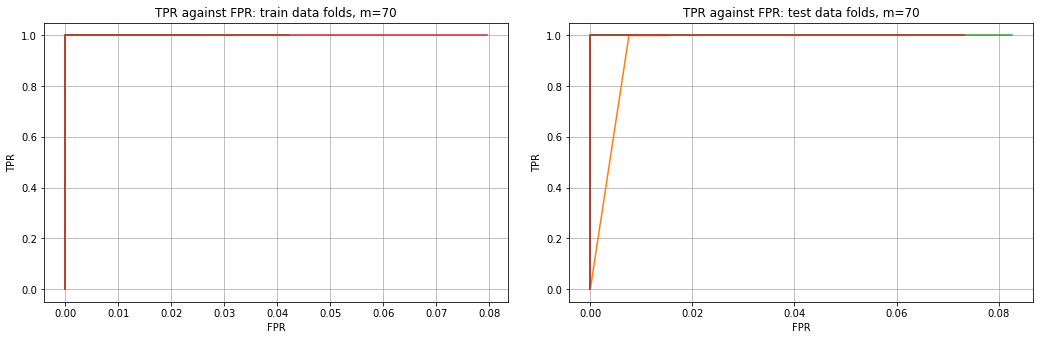

In [45]:
min_prob = 0
max_prob = 1

roc_fig, roc_axes = plt.subplots(1, 2)
roc_fig.set_figheight(5)
roc_fig.set_figwidth(15)
roc_fig.tight_layout(pad=3)

# train ROC
for i in range(folds):
    x_train_probability = sigma(wm_list[i][-1], folds_data_list[i][0])
    train_fpr, train_tpr = FPRandTPR(x_train_probability, folds_data_list[i][1], min_prob, max_prob, 100)
    roc_axes[0].plot(train_fpr, train_tpr)

roc_axes[0].set_title('TPR against FPR: train data folds, m=' + str(m))
roc_axes[0].set_xlabel('FPR')
roc_axes[0].set_ylabel('TPR')
roc_axes[0].grid()

# test ROC
for i in range(folds):
    x_test_probability = sigma(wm_list[i][-1], folds_data_list[i][2])
    test_fpr, test_tpr = FPRandTPR(x_test_probability, folds_data_list[i][3], min_prob, max_prob, 100)
    roc_axes[1].plot(test_fpr, test_tpr)

roc_axes[1].set_title('TPR against FPR: test data folds, m=' + str(m))
roc_axes[1].set_xlabel('FPR')
roc_axes[1].set_ylabel('TPR')
roc_axes[1].grid()

# 6 - Future Data

Read data from "FutureData" directory:

In [46]:
future_rad_list, future_intensity_mat, future_filenames = getImagesFromDirectory("FutureData", 500)
future_rad_list, future_intensity_mat = cutFirstAndLastRadiiAndIntensity(future_rad_list, future_intensity_mat)
future_mat = normalizeMatCols(future_intensity_mat)
future_mat = addOnesCol(future_mat)

Train the classifier over all the 1000 images.<br>
Note: the data is not shuffled. First 500 images are fake (tagged 1), last 500 images are real (tagged 0).

In [47]:
m = 70
alpha = 0.08
w0 = 0.001
threshold = 0.5

In [48]:
x2 = addOnesCol(data_mat)
y2 = np.zeros(x2.shape[0])
y2[0:int(y2.shape[0]/2)] = 1
w0_vec = np.ones(x2.shape[1]) * w0
wm = gradientDescent(w0_vec, x2, y2, alpha, m)

Classify the images and save to file:

In [49]:
def classifyFutureDataInFile(intensity_mat, wm, threshold, filenames):
    f = open('FutureDataEstimatedLabels.csv', 'w')
    writer = csv.writer(f)
    for i in range(intensity_mat.shape[0]):
        line = ""
        probability = sigma(wm, intensity_mat[i])
        if (probability > threshold):
            line = filenames[i] + ", Fake\n"
        else:
            line = filenames[i] + ", Real\n"
        f.write(line)
    f.close()


In [50]:
classifyFutureDataInFile(future_mat, wm, threshold, future_filenames)